In [1]:
import os
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import random_split


In [2]:
class OvarianDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, row["Image"])
        label = int(row["cancer"])   # 0 or 1

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
# Transforming the image into a localized tensor

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [4]:
_DIR = "dataset/KaggleUltrasound/"
dataset = OvarianDataset(
    csv_file=f"{_DIR}labels.csv",
    img_dir=f"{_DIR}images",
    transform=transform
)


In [5]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)   # binary output

model = model.to(device)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_data = []


In [16]:
# Continual training on the resnet with the aditional layer
epochs = 10

for epoch in range(epochs):

    model.train()
    train_loss = 0

    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss_data.append(loss.item())

    print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}")


Epoch 1 Train Loss: 13.1995
Epoch 2 Train Loss: 7.7853
Epoch 3 Train Loss: 4.7797
Epoch 4 Train Loss: 3.1550
Epoch 5 Train Loss: 2.1779
Epoch 6 Train Loss: 1.5802
Epoch 7 Train Loss: 1.0723
Epoch 8 Train Loss: 0.6908
Epoch 9 Train Loss: 0.8770
Epoch 10 Train Loss: 0.4830


In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():

    for images, labels in val_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Validation Accuracy:", correct/total)


Validation Accuracy: 0.9387755102040817


In [18]:
torch.save(model.state_dict(), "model_archives/KaggleUltrasound/resnet_continual.pth")


In [19]:
class_counts = dataset.df["cancer"].value_counts()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))


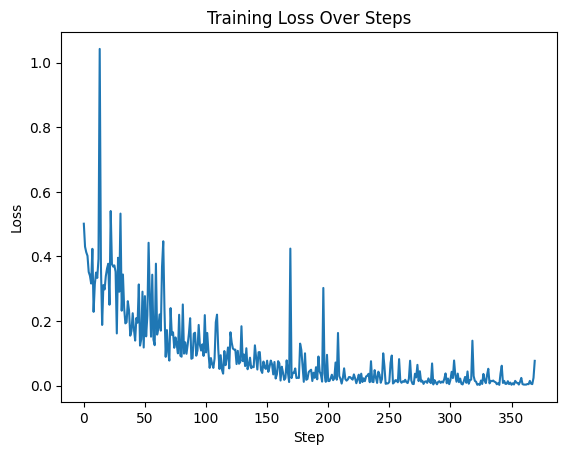

In [20]:
import matplotlib.pyplot as plt

# ----- Plot Training Loss -----
plt.figure()
plt.plot(loss_data)
plt.title("Training Loss Over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

